### Setup: Import Dependencies
Run the cell below to import the relevant dependencies.

In [107]:
import functools

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch

### Part 1: CMA-ES
Implement CMA-ES below.

In [272]:
def cmaes(fn, dim, num_iter=10, fixed_param:bool=False, initial_mu=None, eval_interv=10):
    """Optimizes a given function using CMA-ES..

    Args:
      fn: A function that takes as input a vector and outputs a scalar value.
      dim: (int) The dimension of the vector that fn expects as input.
      num_iter: (int) Number of iterations to run CMA-ES.

    Returns:
      mu_vec: An array of size [num_iter, dim] storing the value of mu at each
        iteration.
      best_sample_vec: A list of length [num_iter] storing the function value
        for the best sample from each iteration of CMA-ES.
      mean_sample_vec: A list of length [num_iter] storing the average function
        value across samples from each iteration of CMA-ES.
    """
    def update_gaussian_params(best_param, noise):
        return np.mean(best_param, axis=0), np.cov(best_param.T) + noise*np.eye(best_param.shape[1])
    
    # Hyperparameters
    sigma = 10
    population_size = 100
    p_keep = 0.10  # Fraction of population to keep
    noise = 0.25  # Noise added to covariance to prevent it from going to 0.

    # Initialize the mean and covariance
    if initial_mu is None:
        mu = np.zeros(dim)
    else: 
        mu = initial_mu
        assert len(mu)==dim
    cov = sigma**2 * np.eye(dim)
    # initialize arr 
    mu_vec = []
    best_sample_vec = []
    mean_sample_vec = []
    for t in range(num_iter):
        # WRITE CODE HERE
        sampled_pupulation = np.random.multivariate_normal(mu, cov, size=(population_size,))
        fitness = np.apply_along_axis(func1d=fn, axis=1, arr=sampled_pupulation)
        rank_idx = fitness.argsort()[::-1][:int(population_size*p_keep)]
        best_population = sampled_pupulation[rank_idx]
        # 
        if not fixed_param:
            mu, cov = update_gaussian_params(best_population, noise)
        mu_vec.append(mu)
        best_sample_vec.append(fitness[rank_idx[0]])
        mean_sample_vec.append(np.mean(fitness))
        #
        if t%eval_interv==0: print(f"fitness:{mean_sample_vec[-1]}")
    return np.concatenate([mu_vec]), np.concatenate([best_sample_vec]), np.concatenate([mean_sample_vec])

In the cell below, we've defined a simply function:
$$f(x) = -\|x - x^*\|_2^2 \quad \text{where} \quad x^* = [65, 49].$$
This function is optimized when $x = x^*$. Run your implementation of CMA-ES on this function, confirming that you get the correct solution. 

In [273]:
def test_fn(x):
    goal = np.array([65, 49])
    return -np.sum((x - goal) ** 2)

mu_vec, best_sample_vec, mean_sample_vec = cmaes(test_fn, dim=2, num_iter=100)

fitness:-6474.108568484499
fitness:-2840.5954012454213
fitness:-1893.6311089925764
fitness:-1151.0379125413522
fitness:-606.8749746970092
fitness:-198.22319388059316
fitness:-21.820232449653286
fitness:-0.5003087598806413
fitness:-0.4351738751709312
fitness:-0.5433643010299752


Run the following cell to visualize CMA-ES.

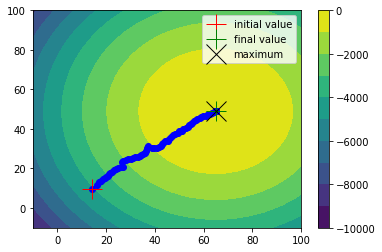

In [278]:
x = np.stack(np.meshgrid(np.linspace(-10, 100, 30), np.linspace(-10, 100, 30)), axis=-1)
fn_value = [test_fn(xx) for xx in x.reshape((-1, 2))]
fn_value = np.array(fn_value).reshape((30, 30))
plt.figure(figsize=(6, 4))
plt.contourf(x[:, :, 0], x[:, :, 1], fn_value, levels=10)
plt.colorbar()
mu_vec = np.array(mu_vec)
plt.plot(mu_vec[:, 0], mu_vec[:, 1], "b-o")
plt.plot([mu_vec[0, 0]], [mu_vec[0, 1]], "r+", ms=20, label="initial value")
plt.plot([mu_vec[-1, 0]], [mu_vec[-1, 1]], "g+", ms=20, label="final value")
plt.plot([65], [49], "kx", ms=20, label="maximum")
plt.legend()
plt.savefig("Q1.1.jpg")
plt.show()


Next, you will apply CMA-ES to a more complicating: maximizing the expected reward of a RL agent. The policy takes action LEFT with probability:
$$\pi(a = \text{LEFT} \mid s) = s \cdot w + b,$$
where $w \in \mathbb{R}^4$ and $b \in \mathbb{R}$ are parameters that you will optimize with CMA-ES. In the cell below, define a function that takes as input a single vector $x = (w, b)$ and the environment and returns the total (undiscounted) reward from one episode.

In [214]:
def _sigmoid(x):
    return 1 / (1 + np.exp(-x))

class model(torch.nn.Sequential):
    def __init__(self, n_state=4, n_act=1):
        super().__init__()
        self.lin_reg = torch.nn.Linear(n_state, n_act)
    
    def forward(self, x):
        x = self.lin_reg(x)
        return torch.nn.Sigmoid()(x)

def get_model_params(model):
    return torch.concat(list(map(torch.flatten,list(list(m.children())[0].parameters()))))
        
def _get_action(s, params):
    w = params[:4]
    b = params[4]
    p_left = _sigmoid(w @ s + b)
    a = np.random.choice(2, p=[p_left, 1 - p_left])
    return a

def rl_fn(params, env):
    # input states is 4 dim
    assert len(params) == 5
    s = env.reset()
    terminal = False
    total_rewards = 0
    while not terminal:
        a = _get_action(s, params)
        s, r, terminal, _ = env.step(a)
        total_rewards += r
    return total_rewards

The cell below applies your CMA-ES implementation to the RL objective you've defined in the cell above.

In [268]:
def plot_stuff(mu_vec, mean_sample_vec, best_sample_vec=None, graph_name:str="Q1.2-1.jpg"):
    fig, ax = plt.subplots(1, 3, figsize=(15,4))
    ax[0].plot(mu_vec)
    ax[0].set_title("Params"); ax[0].legend([f'w{i}' for i in range(4)]+['b'])
    ax[1].plot(mean_sample_vec)
    ax[1].set_title("Mean Reward")
    ax[1].text(0.8, 0.9, f"Mean:{np.mean(mean_sample_vec):.2f}", transform=ax[1].transAxes)
    ax[2].plot(best_sample_vec)
    ax[2].set_title("Best Reward")
    fig.savefig(f"figures/{graph_name}")

fitness:21.13
fitness:20.36
fitness:17.04
fitness:17.52
fitness:17.75
fitness:17.62
fitness:14.06
fitness:16.15
fitness:22.0
fitness:21.08
fitness:19.75
fitness:16.6
fitness:19.45
fitness:14.86
fitness:23.08
fitness:16.66
fitness:21.76
fitness:16.28
fitness:15.37
fitness:16.09
fitness:13.84
fitness:26.03
fitness:18.1
fitness:22.9
fitness:13.95
fitness:22.68
fitness:21.72
fitness:19.29
fitness:17.34
fitness:22.33
fitness:18.25
fitness:22.0
fitness:13.76
fitness:15.91
fitness:19.73
fitness:19.3
fitness:16.19
fitness:17.08
fitness:23.65
fitness:18.11
fitness:20.31
fitness:21.02
fitness:21.51
fitness:16.2
fitness:16.7
fitness:22.29
fitness:19.64
fitness:19.0
fitness:17.4
fitness:15.66
fitness:12.6
fitness:17.67
fitness:14.16
fitness:18.69
fitness:17.48
fitness:15.85
fitness:17.32
fitness:18.28
fitness:19.14
fitness:15.13
fitness:15.33
fitness:15.5
fitness:16.4
fitness:19.5
fitness:19.67
fitness:19.97
fitness:20.25
fitness:16.34
fitness:17.39
fitness:19.5
fitness:19.53
fitness:20.86
fitness

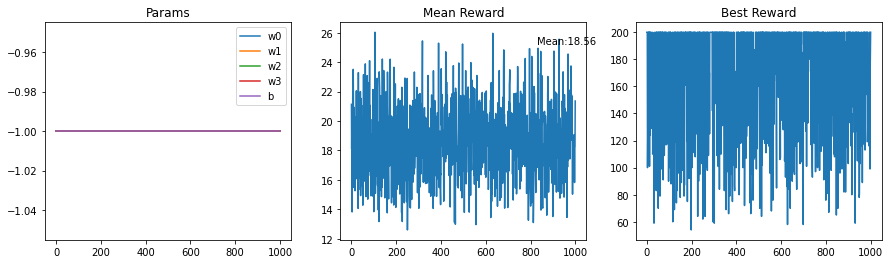

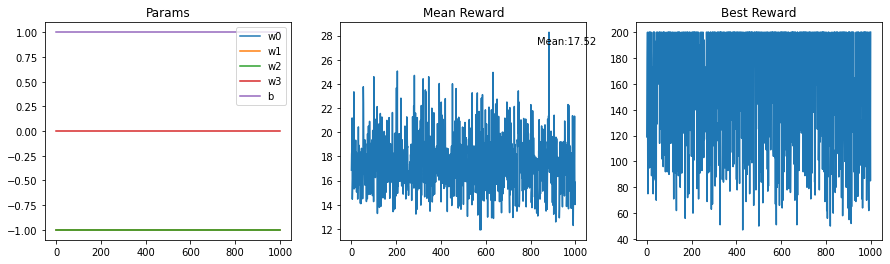

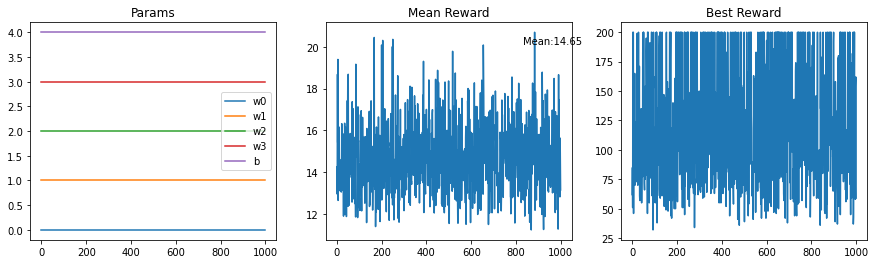

In [269]:
env = gym.make("CartPole-v0")
fn_with_env = functools.partial(rl_fn, env=env)
for graph_name, mu_vec in {"Q1.2-1.jpg":np.full(5, -1), "Q1.2-2.jpg":np.array([-1,-1,-1,0,1]), "Q1.2-3.jpg":np.arange(5)}.items():
    mu_vec, best_sample_vec, mean_sample_vec = cmaes(fn_with_env, dim=5, num_iter=1000,fixed_param=True, initial_mu=mu_vec)
    plot_stuff(mu_vec, mean_sample_vec, best_sample_vec, graph_name)

In [ ]:
mu_vec, best_sample_vec, mean_sample_vec = cmaes(fn_with_env, dim=5, num_iter=1000,fixed_param=False)
plot_stuff(mu_vec, mean_sample_vec, best_sample_vec, "Q1.3.jpg")